# Transformation Matrix
A Patent-to-Product Transformation Matrix is a mathematical structure (often a 2D matrix) that helps map technical terms or content from patents to related products or product keywords.

# Step 1: Import libraries

* pandas and numpy: for data handling
* gensim: for loading word vectors
* torch: for building a small neural network
* sklearn: for splitting data
* matplotlib: for drawing loss graphs



In [84]:
!pip install numpy==1.26.4 scipy==1.13.0 gensim==4.3.3 hanziconv

In [85]:
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Step 2: Download aligned vector
* Aligned vectors mean: Words from different languages are mapped into the same vector space, so they can be compared directly.


In [86]:
import urllib.request
import os

def download_aligned_vec(lang, target_dir='.'):
    assert lang in ('en', 'zh')
    os.makedirs(target_dir, exist_ok=True)

    filename = f'wiki.{lang}.align.vec'
    out_path = os.path.join(target_dir, filename)

    # Skip download if file already exists
    if os.path.exists(out_path):
        print(f'{filename} already exists. Skipping download.')
        return out_path

    url = f'https://dl.fbaipublicfiles.com/fasttext/vectors-aligned/{filename}'
    print(f'Downloading {lang} aligned vector: {url}')
    urllib.request.urlretrieve(url, out_path)
    print(f'Saved to {out_path}')
    return out_path

lst = ['en']

for lg in lst:
    download_aligned_vec(lg, target_dir='./CN_JP_US_data')
    # download_aligned_vec(lg, target_dir=os.getcwd())    
    

wiki.en.align.vec already exists. Skipping download.


# Step 3: Load patent data with keyword data for three countries

* fastText provides aligned vectors for English and Chinese, but not for Japanese. Aligned Japanese vectors placed in the folder /CN_JP_US_data.
* all needed data are places in the folder /CN_JP_US_data.
* DualAtt_Firm_Product_Keywords_With_Embedding.csv is the file that stores the keywords extracted using the dual attention model.



In [87]:
data_info = {
    'CN': {
        'patent_file': '/content/CN_JP_US_data/cn_patent.csv',
        'fasttext_model': '/content/CN_JP_US_data/wiki.zh.align.vec',
        'output_model': '/content/CN_JP_US_data/patent2product_cn.pt'
    },
    'JP': {
        'patent_file': '/content/CN_JP_US_data/jp_patent.csv',
        'fasttext_model': '/content/CN_JP_US_data/vectors-ja.txt',
        'output_model': '/content/CN_JP_US_data/patent2product_jp.pt'
    },
    # 'US': {
    #     'patent_file': '/content/CN_JP_US_data/us_patent.csv',
    #     'fasttext_model': '/content/CN_JP_US_data/wiki.en.align.vec',
    #     'output_model': '/content/CN_JP_US_data/patent2product_us.pt'
    # }
    'US': {
        # 'patent_file': './CN_JP_US_data/us_patent202506.csv',
        'patent_file': './CN_JP_US_data/cleaned_patents.csv',
        # 'fasttext_model': './CN_JP_US_data/wiki.en.align.vec',
        'fasttext_model': 'fasttext_web_patent.vec',
        'output_model': './CN_JP_US_data/patent2product_us.pt'
    }
}

keyword_df = pd.read_csv('./CN_JP_US_data/DualAtt_Firm_Product_Keywords_With_Embedding.csv')
keyword_df

Firm ID     Firm name Firm country  \
0                  1    平安银行股份有限公司           CN   
1                  2    万科企业股份有限公司           CN   
2                  5  深圳世纪星源股份有限公司           CN   
3                  8  神州高铁技术股份有限公司           CN   
4                 12  中国南玻集团股份有限公司           CN   
...              ...           ...          ...   
14305  9500001002341        セキ株式会社           JP   
14306  9500001003380  株式会社ファインデックス           JP   
14307  9500001003505        株式会社フジ           JP   
14308  9500001014345      大王製紙株式会社           JP   
14309  9500001015681    ベルグアース株式会社           JP   

                                           Keywords list  \
0      股份|技术|先进|应用|研发|产品|掌握|财务|销售|实际|设备|综合|智能|权益|手机|多...   
1      行业|股份|开发|提升|应用|产品|资讯|领先|更好|物业|处理|升级|综合|先进|带来|正...   
2      技术|工艺|先进|处理|装备|高效|工业|全量|en|科技|支撑|人工|机械|储备|解决|土...   
3      技术|股份|行业|研发|数据|有限公司|装备|工业|有效|开发|致远|科技|财务|荣获|专利...   
4      销售|技术|行业|产品|先进|研发|应用|升级|提升|工艺|电站|处理|领先|领域|云端|综...   
...                                                  ...   
14305  新着|出展|並びに|商社|会社|として|案内|定める|洋画|自身|サントリー|セキ|手数料|...   
14306  procap|ウェアラブルデバイス|放射線|remora|ris|カルテ|学会|pcm|製品...   
14307  個体|店頭|美味しい|持ち寄っ|雑貨|口当たり|柳井|売場|穀物|モス|承り|青果|積ん|別...   
14308  紙おむつ|製品|エミッション|手提|ncp|個体|剥がす|画用紙|剥がれ|全量|ウェット|p...   
14309  ベルグアース|接木|接ぎ木|ベルグ|サントリーフラワーズ|挿し木|製品|ハイレッグ|菜園|貯...   

                                               Embedding  
0      [-0.009783665649592876, -0.032082561403512955,...  
1      [-0.024668600410223007, -0.03433723375201225, ...  
2      [-0.017936067655682564, -0.05135698243975639, ...  
3      [-0.030632132664322853, -0.029921503737568855,...  
4      [-0.02446485310792923, -0.0055235689505934715,...  
...                                                  ...  
14305  [-0.0006731715402565897, -0.012971415184438229...  
14306  [0.04441870003938675, -0.053930044174194336, -...  
14307  [-0.02534634619951248, 0.02230890840291977, -0...  
14308  [-0.02100982517004013, -0.011774472892284393, ...  
14309  [0.009140873327851295, -0.015613018535077572, ...  

[14310 rows x 5 columns]

In [88]:
keyword_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14310 entries, 0 to 14309
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Firm ID        14310 non-null  int64 
 1   Firm name      14310 non-null  object
 2   Firm country   14310 non-null  object
 3   Keywords list  14310 non-null  object
 4   Embedding      14310 non-null  object
dtypes: int64(1), object(4)
memory usage: 559.1+ KB


In [89]:
keyword_df.nunique()

Firm ID          14310
Firm name        14304
Firm country         3
Keywords list    13716
Embedding        13716
dtype: int64

In [90]:
keyword_df[keyword_df['Firm country'] == 'US']

Firm ID                            Firm name Firm country  \
3465    700000                     Warrior Met Coal           US   
3466    700001  MAGNACHIP SEMICONDUCTOR CORPORATION           US   
3467    700002                         Agree Realty           US   
3468    700003                 Ryan Specialty Group           US   
3469    700004                 CLEARSHARES OCIO ETF           US   
...        ...                                  ...          ...   
10353   706916           Armstrong World Industries           US   
10354   706917                               R1 RCM           US   
10355   706918              HENNESSY ADVISORS, INC.           US   
10356   706919      GABELLI DIVIDEND & INCOME TRUST           US   
10357   706920               SecureTech Innovations           US   

                                           Keywords list  \
3465   longwall|supplier|discharges|mined|coking|prod...   
3466   dissipation|igbts|patents|needham|2020|smartph...   
3467   properties|estate|acquire|ranson|gnc|forest|st...   
3468   carriers|insured|wholesale|fatca|scoop|llc|org...   
3469   2024|quasar|securities|proprietary|cum|sold|se...   
...                                                  ...   
10353  acoustical|commercial|thermal|english|towers|g...   
10354  cost|specialized|clinical|microsofts|technolog...   
10355  funds|assets|locally|2021|2023|firm|nearly|435...   
10356  sicav|cellulose|trustee|1007|2024|firm|olin|ar...   
10357  blockchain|securities|technologies|mr|underway...   

                                               Embedding  
3465   [-0.04066617786884308, 0.006512229330837727, -...  
3466   [-0.0018086755881085992, 0.03016837127506733, ...  
3467   [-0.03614979237318039, -0.03544622287154198, -...  
3468   [-0.022926554083824158, -0.00715073524042964, ...  
3469   [-0.04673175886273384, -0.0346466489136219, -0...  
...                                                  ...  
10353  [-0.038657814264297485, 0.011968007311224937, ...  
10354  [-0.0259347315877676, -0.00040884839836508036,...  
10355  [-0.04091133549809456, -0.03133635222911835, -...  
10356  [-0.029761411249637604, -0.047938887029886246,...  
10357  [-0.00589645653963089, -0.049870654940605164, ...  

[6893 rows x 5 columns]

In [91]:
if 'Product embedding vector' not in keyword_df.columns:
    keyword_df.insert(keyword_df.columns.get_loc('Keywords list') + 1, 'Product embedding vector', '')
    
keyword_df['Product embedding vector'] = ''

In [92]:
keyword_df

Firm ID     Firm name Firm country  \
0                  1    平安银行股份有限公司           CN   
1                  2    万科企业股份有限公司           CN   
2                  5  深圳世纪星源股份有限公司           CN   
3                  8  神州高铁技术股份有限公司           CN   
4                 12  中国南玻集团股份有限公司           CN   
...              ...           ...          ...   
14305  9500001002341        セキ株式会社           JP   
14306  9500001003380  株式会社ファインデックス           JP   
14307  9500001003505        株式会社フジ           JP   
14308  9500001014345      大王製紙株式会社           JP   
14309  9500001015681    ベルグアース株式会社           JP   

                                           Keywords list  \
0      股份|技术|先进|应用|研发|产品|掌握|财务|销售|实际|设备|综合|智能|权益|手机|多...   
1      行业|股份|开发|提升|应用|产品|资讯|领先|更好|物业|处理|升级|综合|先进|带来|正...   
2      技术|工艺|先进|处理|装备|高效|工业|全量|en|科技|支撑|人工|机械|储备|解决|土...   
3      技术|股份|行业|研发|数据|有限公司|装备|工业|有效|开发|致远|科技|财务|荣获|专利...   
4      销售|技术|行业|产品|先进|研发|应用|升级|提升|工艺|电站|处理|领先|领域|云端|综...   
...                                                  ...   
14305  新着|出展|並びに|商社|会社|として|案内|定める|洋画|自身|サントリー|セキ|手数料|...   
14306  procap|ウェアラブルデバイス|放射線|remora|ris|カルテ|学会|pcm|製品...   
14307  個体|店頭|美味しい|持ち寄っ|雑貨|口当たり|柳井|売場|穀物|モス|承り|青果|積ん|別...   
14308  紙おむつ|製品|エミッション|手提|ncp|個体|剥がす|画用紙|剥がれ|全量|ウェット|p...   
14309  ベルグアース|接木|接ぎ木|ベルグ|サントリーフラワーズ|挿し木|製品|ハイレッグ|菜園|貯...   

      Product embedding vector  \
0                                
1                                
2                                
3                                
4                                
...                        ...   
14305                            
14306                            
14307                            
14308                            
14309                            

                                               Embedding  
0      [-0.009783665649592876, -0.032082561403512955,...  
1      [-0.024668600410223007, -0.03433723375201225, ...  
2      [-0.017936067655682564, -0.05135698243975639, ...  
3      [-0.030632132664322853, -0.029921503737568855,...  
4      [-0.02446485310792923, -0.0055235689505934715,...  
...                                                  ...  
14305  [-0.0006731715402565897, -0.012971415184438229...  
14306  [0.04441870003938675, -0.053930044174194336, -...  
14307  [-0.02534634619951248, 0.02230890840291977, -0...  
14308  [-0.02100982517004013, -0.011774472892284393, ...  
14309  [0.009140873327851295, -0.015613018535077572, ...  

[14310 rows x 6 columns]

# Step 3B: Our data after training the Dual Att Model 

In [93]:
our_dual_att_result = pd.read_csv(
    # r'C:\PDZ\Intern\Shared_2025\Phase 2\Checkpoint\full_company_embeddings.csv',
    r'C:\PDZ\Intern\Shared_2025\Phase 2\Multi_label\DualAttenMultilabel_Result\results_300_300_13labels\full_company_embeddings_multilabel.csv',
    index_col=0
)
our_dual_att_result

company_keywords
hojin_id                                                   
700000    community|equipment|totaling|transit|highway|v...
700001    manufactures|improvement|manufacture|improved|...
700002    developer|media|property|consenting|partner|su...
700003    outcomes|consisting|distribute|experience|insu...
700004    virtually|potential|investments|integrates|str...
...                                                     ...
706916    curtain|travel|inspiring|fiberglass|experience...
706917    outcomes|community|experience|specialized|regu...
706918    filings|followed|including|ideals|covering|dis...
706919    estimated|stickiness|insecticides|covering|com...
706920    cryptocurrency|filings|starting|websites|exper...

[6764 rows x 1 columns]

In [94]:
data_path = r"C:\PDZ\Intern\Shared_2025\Phase 2\CN_JP_US_data\us_web_with_company.csv"
us_web_with_company = pd.read_csv(data_path)
# us_web_with_company = us_web_with_company[us_web_with_company['hightechflag'] == 1]
us_web_with_company


hojin_id           company_name  \
0        703454  Wall Street Media Co.   
1        703454  Wall Street Media Co.   
2        703454  Wall Street Media Co.   
3        703454  Wall Street Media Co.   
4        703454  Wall Street Media Co.   
...         ...                    ...   
64638    705967      Plus Therapeutics   
64639    706491      micromobility.com   
64640    706491      micromobility.com   
64641    706491      micromobility.com   
64642    706491      micromobility.com   

                                                     url    weight  \
0               https://wallstreetmediaco.net/investors/  0.027877   
1      https://wallstreetmediaco.net/a-i-powers-the-f...  0.123040   
2      https://wallstreetmediaco.net/green-retail-and...  0.106928   
3      https://wallstreetmediaco.net/pebble-life-scie...  0.101823   
4                         https://wallstreetmediaco.net/  0.096351   
...                                                  ...       ...   
64638                      https://plustherapeutics.com/  0.238283   
64639  https://micromobility.com/account/login?return...  0.154904   
64640    https://micromobility.com/pages/shared-mobility  0.329354   
64641                      https://ir.micromobility.com/  0.242320   
64642                         https://micromobility.com/  0.273422   

                                                    text  \
0      wallstreetmediaconet|wallstreetcom|millennials...   
1      media|future|multimedia|technology|technologie...   
2      green|environmentally|environment|marketing|jo...   
3      innovation|innovations|innovators|innovative|h...   
4      innovation|innovations|innovators|news|new|tec...   
...                                                  ...   
64638  cancer|radiotherapeutics|cancers|carcinoma|rad...   
64639  micromobilitycom|long|scooters|policy|password...   
64640  micromobilitycom|traffic|mapbox|transportation...   
64641  micromobilitycom|events|investors|investor|opp...   
64642  micromobilitycom|scooters|bikes|micromobility|...   

                                                   sents  hightechflag  \
0      nasdaq|following|raymond|otcqb|concentrated|as...           0.0   
1      reward|augment|accuracy|gold|assets|january|te...           0.0   
2      march|materials|general|heat|margins|sellers|b...           0.0   
3      harness|reported|hope|machine|january|preventi...           0.0   
4      mastering|march|manufacture|borqs|august|danie...           0.0   
...                                                  ...           ...   
64638  radiotherapeutic|colorectal|drug|patents|radia...           1.0   
64639          cart|terms|mail|content|personal|scooters           0.0   
64640  vehicles|infrastructure|safer|mopeds|cleaner|c...           0.0   
64641  navigation|soon|nasdaq|mcom|constructive|decem...           0.0   
64642  electric|cart|terms|content|shipping|products|...           0.0   

       us_flag  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
64638        1  
64639        1  
64640        1  
64641        1  
64642        1  

[64643 rows x 8 columns]

In [95]:
# Keep only necessary columns from `us_web_with_company`
company_name_map = us_web_with_company[['hojin_id', 'company_name']].drop_duplicates()

# Merge based on hojin_id
merged_df = our_dual_att_result.merge(company_name_map, on='hojin_id', how='left')
merged_df

hojin_id                                   company_keywords  \
0       700000  community|equipment|totaling|transit|highway|v...   
1       700001  manufactures|improvement|manufacture|improved|...   
2       700002  developer|media|property|consenting|partner|su...   
3       700003  outcomes|consisting|distribute|experience|insu...   
4       700004  virtually|potential|investments|integrates|str...   
...        ...                                                ...   
6759    706916  curtain|travel|inspiring|fiberglass|experience...   
6760    706917  outcomes|community|experience|specialized|regu...   
6761    706918  filings|followed|including|ideals|covering|dis...   
6762    706919  estimated|stickiness|insecticides|covering|com...   
6763    706920  cryptocurrency|filings|starting|websites|exper...   

                             company_name  
0                        Warrior Met Coal  
1     MAGNACHIP SEMICONDUCTOR CORPORATION  
2                            Agree Realty  
3                    Ryan Specialty Group  
4                    CLEARSHARES OCIO ETF  
...                                   ...  
6759           Armstrong World Industries  
6760                               R1 RCM  
6761              HENNESSY ADVISORS, INC.  
6762      GABELLI DIVIDEND & INCOME TRUST  
6763               SecureTech Innovations  

[6764 rows x 3 columns]

In [96]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6764 entries, 0 to 6763
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   hojin_id          6764 non-null   int64 
 1   company_keywords  6764 non-null   object
 2   company_name      6764 non-null   object
dtypes: int64(1), object(2)
memory usage: 158.7+ KB


In [97]:
merged_df.nunique()

hojin_id            6764
company_keywords    6009
company_name        6764
dtype: int64

In [98]:
if 'Product embedding vector' not in merged_df.columns:
    merged_df.insert(merged_df.columns.get_loc('company_keywords') + 1, 'Product embedding vector', '')
    
merged_df['Product embedding vector'] = ''

In [99]:
# Rename columns
merged_df = merged_df.rename(columns={
    'hojin_id': 'Firm ID',
    'company_name': 'Firm name',
    'company_keywords': 'Keywords list',
    'embedding': 'Embedding'
})

In [100]:
merged_df['Firm country'] = 'US'

In [101]:
keyword_df = merged_df
keyword_df

Firm ID                                      Keywords list  \
0      700000  community|equipment|totaling|transit|highway|v...   
1      700001  manufactures|improvement|manufacture|improved|...   
2      700002  developer|media|property|consenting|partner|su...   
3      700003  outcomes|consisting|distribute|experience|insu...   
4      700004  virtually|potential|investments|integrates|str...   
...       ...                                                ...   
6759   706916  curtain|travel|inspiring|fiberglass|experience...   
6760   706917  outcomes|community|experience|specialized|regu...   
6761   706918  filings|followed|including|ideals|covering|dis...   
6762   706919  estimated|stickiness|insecticides|covering|com...   
6763   706920  cryptocurrency|filings|starting|websites|exper...   

     Product embedding vector                            Firm name  \
0                                                 Warrior Met Coal   
1                              MAGNACHIP SEMICONDUCTOR CORPORATION   
2                                                     Agree Realty   
3                                             Ryan Specialty Group   
4                                             CLEARSHARES OCIO ETF   
...                       ...                                  ...   
6759                                    Armstrong World Industries   
6760                                                        R1 RCM   
6761                                       HENNESSY ADVISORS, INC.   
6762                               GABELLI DIVIDEND & INCOME TRUST   
6763                                        SecureTech Innovations   

     Firm country  
0              US  
1              US  
2              US  
3              US  
4              US  
...           ...  
6759           US  
6760           US  
6761           US  
6762           US  
6763           US  

[6764 rows x 5 columns]

In [102]:
keyword_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6764 entries, 0 to 6763
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Firm ID                   6764 non-null   int64 
 1   Keywords list             6764 non-null   object
 2   Product embedding vector  6764 non-null   object
 3   Firm name                 6764 non-null   object
 4   Firm country              6764 non-null   object
dtypes: int64(1), object(4)
memory usage: 264.3+ KB


In [103]:
# Ensure Firm ID is string (for consistency with other dicts)
keyword_df['Firm ID'] = keyword_df['Firm ID'].astype(str)

# Create the mapping: Firm ID → Firm name
firm_id_name_map = dict(zip(keyword_df['Firm ID'], keyword_df['Firm name']))
firm_id_name_map

{'700000': 'Warrior Met Coal',
 '700001': 'MAGNACHIP SEMICONDUCTOR CORPORATION',
 '700002': 'Agree Realty',
 '700003': 'Ryan Specialty Group',
 '700004': 'CLEARSHARES OCIO ETF',
 '700005': '23andMe',
 '700006': 'Reneo Pharmaceuticals',
 '700007': 'KORRO BIO INC',
 '700008': 'HealthEquity',
 '700009': '4Cable TV',
 '700010': 'CREDIT SUISSE ASSET MANAGEMENT INCOME FUND, INC.',
 '700011': 'Hyster-Yale Materials Handling',
 '700012': 'Sprout Social',
 '700013': 'Solid Power',
 '700014': 'Location Based Technologies',
 '700015': 'NORTHEAST BANK',
 '700016': 'AXIL BRANDS INC',
 '700017': 'Dakota Territory Resource',
 '700018': 'DEER CONSUMER PRODUCTS, INC .',
 '700019': 'Hologic',
 '700020': 'Cara Therapeutics',
 '700021': 'Hollywall Entertainment',
 '700022': 'Playa Hotels & Resorts',
 '700023': 'HealthStream',
 '700024': 'NORTHRIM BANCORP, INC.',
 '700025': 'CMS Energy Corporation',
 '700026': 'Athira Pharma',
 '700027': 'U.S. Stem Cell',
 '700028': 'S&P 500R EX-HEALTH CARE ETF',
 '700029'

# Step 4: Load data and convert to vectors
* Loads patent and product keyword data.
* Converts text (product keywords and patent abstracts) to vectors using fastText.
* Stores vectors by company ID.
* Keeps only companies that have both patent and product vectors.

In [104]:
def load_gensim_vec(path):
    print(f"Loading vectors: {path}")
    return KeyedVectors.load_word2vec_format(path, binary=False)

In [105]:
# def text_to_vector(text, ft_model):
#     words = text.split('|')
#     vectors = [ft_model[w] for w in words if w.strip() and w in ft_model]
#     if not vectors:
#         return np.zeros(ft_model.vector_size)
#     return np.mean(vectors, axis=0)

from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def text_to_vector(text, ft_model, top_k=3, debug=False):
    words = text.split('|')
    words = [w.strip() for w in words if w.strip()]
    vectors = [ft_model[w] for w in words if w in ft_model]

    if vectors:
        return np.mean(vectors, axis=0)

    return np.zeros(ft_model.vector_size)


In [106]:
import ast  # To safely evaluate string list to real list
from tqdm import tqdm


In [107]:
patent_rep_dict = {}
product_rep_dict = {}
shared_ids = {}
firm_patent_ids = {}  # NEW: Map firm_id → list of appln_ids
patent_text_map = {}  # NEW: Map appln_id → cleaned abstract text


In [108]:
for country, info in data_info.items():
    print(f"\nProcessing: {country}")
    
    if country in ['CN', 'JP']:
        continue  # Skip CN and JP for now

    patent_df = pd.read_csv(info['patent_file'])
    print(f"  Loaded patent file with {len(patent_df)} rows.")

    ft_model = load_gensim_vec(info['fasttext_model'])
    print(f"  Loaded FastText model for {country}.")

    country_indices = keyword_df[keyword_df['Firm country'] == country].index
    for idx in country_indices:
        firm_id = str(keyword_df.at[idx, 'Firm ID'])
        keywords = keyword_df.at[idx, 'Keywords list']
        product_vec = text_to_vector(keywords, ft_model, debug=True)
        product_rep_dict[firm_id] = product_vec

    abstract_col = next((col for col in patent_df.columns if 'clean_abstract' in col.lower()), None)
    if abstract_col is None:
        raise ValueError(f"Can't find {country} patent abstracts")

    print(f"  Using abstract column: {abstract_col}")

    firm_counter = 0  # Limit debug prints to 2 firms
    for firm_id, group in patent_df.groupby('hojin_id'):
        firm_id = str(firm_id)

        raw_lists = group[abstract_col].dropna().tolist()
        appln_ids = group['appln_id'].tolist()
        
        abstracts_with_ids = group[[abstract_col, 'appln_id']].dropna().values.tolist()
        # abstracts_with_ids = group[['patent_abstract', 'appln_id']].dropna().values.tolist()
        
        all_keywords = []

        # New
        for abstract, appln_id in abstracts_with_ids:
            if isinstance(abstract, str):
                try:
                    tokens = eval(abstract) if abstract.startswith('[') else abstract.split()
                except:
                    tokens = abstract.split()
            else:
                tokens = abstract

            all_keywords.extend(tokens)
            patent_text_map[appln_id] = ' '.join(tokens[:20])

        if firm_counter < 2:
            print(f"    Total tokens collected: {len(all_keywords)}")
            print(f"    Sample tokens: {all_keywords[:20]}")
            print(f"    Final joined text preview: {'|'.join(all_keywords[:50])}...")

        all_text = '|'.join(all_keywords)
        patent_vec = text_to_vector(all_text, ft_model, debug=True)

        if firm_counter < 2:
            print(f"    Patent vector norm: {np.linalg.norm(patent_vec):.4f}")

        patent_rep_dict[firm_id] = patent_vec
        firm_patent_ids[firm_id] = appln_ids  # Track associated patents

        firm_counter += 1

    shared_ids_local = list(set(product_rep_dict.keys()) & set(patent_rep_dict.keys()))
    shared_ids[country] = shared_ids_local
    print(f"\nMatched company counts: {len(shared_ids[country])}")

    if len(shared_ids[country]) == 0:
        print(f"  ⚠️ Skip {country}: no matched data")
        continue



Processing: CN

Processing: JP

Processing: US
  Loaded patent file with 1588417 rows.
Loading vectors: fasttext_web_patent.vec
  Loaded FastText model for US.
  Using abstract column: clean_abstract
    Total tokens collected: 952
    Sample tokens: ['invention', 'relates', 'clock', 'synchronization', 'system', 'capable', 'recording', 'data', 'time', 'initiation', 'data', 'transferred', 'one', 'location', 'another', 'calcium', 'carbonate', 'composition', 'contains', 'minor']
    Final joined text preview: invention|relates|clock|synchronization|system|capable|recording|data|time|initiation|data|transferred|one|location|another|calcium|carbonate|composition|contains|minor|amount|kaolin|clay|said|kaolin|clay|present|amount|sufficient|improve|dispersibility|calcium|carbonate|particularly|rubber|matrix|tapping|sleeve|split|along|axis|parallel|longitudinal|axis|pipe|main|tapped|installed|around|main...
    Patent vector norm: 0.3837
    Total tokens collected: 6044
    Sample tokens: ['di

In [109]:
patent_df = pd.read_csv(data_info["US"]['patent_file'])

In [110]:
patent_df

appln_id appln_filing_date    publn_nr  publn_date        bvdid  \
0           454268        2006-03-14     7464209  2008-12-09  US130871985   
1           454269        2008-04-07     7676618  2010-03-09  US130871985   
2           454277        2008-04-07  2008189462  2008-08-07  US130871985   
3           454280        2008-04-07  2008189715  2008-08-07  US130871985   
4           454307        2008-02-05     8228379  2012-07-24  US251843385   
...            ...               ...         ...         ...          ...   
1588412  617298678        2018-03-19  2021099724  2021-04-01  US953685934   
1588413  623456725        2019-11-04  2021377988  2021-12-02  US942404110   
1588414  623456727        2020-12-04  2021153273  2021-05-20  US941672743   
1588415  624073453        1971-10-12     3736664  1973-06-05  US370602744   
1588416  624073458        1971-10-12     3801210  1974-04-02  US370602744   

                                 company_name       patpublnr  \
0        INTERNATIONAL BUSINESS MACHINES CORP     US7464209B2   
1        INTERNATIONAL BUSINESS MACHINES CORP     US7676618B2   
2        INTERNATIONAL BUSINESS MACHINES CORP  US2008189462A1   
3        INTERNATIONAL BUSINESS MACHINES CORP  US2008189715A1   
4                       Teledyne Technologies     US8228379B2   
...                                       ...             ...   
1588412                              Qualcomm  US2021099724A1   
1588413                                 Apple  US2021377988A1   
1588414                                 Intel  US2021153273A1   
1588415                           Caterpillar      US3736664A   
1588416                           Caterpillar      US3801210A   

                                           patent_abstract  hojin_id  ayear  \
0        A resource and partition manager of the prefer...    702696   2006   
1        A resource and partition manager of the prefer...    702696   2008   
2        A resource and partition manager of the prefer...    702696   2008   
3        A resource and partition manager of the prefer...    702696   2008   
4        In a night vision arrangement for a motor vehi...    700276   2008   
...                                                    ...       ...    ...   
1588412  Methods and devices for decoding including a p...    704946   2018   
1588413  A device of a New Radio (NR) User Equipment (U...    703151   2019   
1588414  Provided herein are apparatus and methods for ...    701309   2020   
1588415  A quickly and easily replaceable cutting edge ...    706299   1971   
1588416  A retaining means for an earth-working tip mem...    706299   1971   

         abstract_length                                     clean_abstract  
0                    124  ['resource', 'partition', 'manager', 'preferre...  
1                    119  ['resource', 'partition', 'manager', 'preferre...  
2                    119  ['resource', 'partition', 'manager', 'preferre...  
3                    119  ['resource', 'partition', 'manager', 'preferre...  
4                    118  ['night', 'vision', 'arrangement', 'motor', 'v...  
...                  ...                                                ...  
1588412              148  ['method', 'device', 'decoding', 'including', ...  
1588413              121  ['device', 'new', 'radio', 'nr', 'user', 'equi...  
1588414              142  ['provided', 'herein', 'apparatus', 'method', ...  
1588415              103  ['quickly', 'easily', 'replaceable', 'cutting'...  
1588416               90  ['retaining', 'mean', 'tip', 'member', 'mean',...  

[1588417 rows x 12 columns]

In [111]:
patent_df.nunique()

appln_id             1588417
appln_filing_date      16928
publn_nr             1588417
publn_date              3893
bvdid                   2860
company_name            2860
patpublnr            1588417
patent_abstract      1307855
hojin_id                2922
ayear                     80
abstract_length          548
clean_abstract       1286453
dtype: int64

# Step 5: Prepare training data
* Creates training input (X_all) and output (Y_all) matrices for companies with matched data.
* Then splits them into training and validation sets, and converts them into PyTorch tensors.

In [112]:
models_A = {}
models_B = {}

losses_A = {}
losses_B = {}

transformation_matrices_A = {}
transformation_matrices_B = {}


# Step 6: Define and train the mapping model
* Defines a small neural network to map patent vectors to product vectors.
* Trains the model using MSE loss for 10 epochs and tracks both training and validation loss.

In [113]:
EPOCH = 100

## Model A (Patent → Product) → Market vector = A × Technology vector

In [114]:
class Patent2Product(nn.Module):
    def __init__(self, dim=ft_model.vector_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, dim)
        )
    def forward(self, x):
        return self.net(x)
    

In [115]:
for country, info in data_info.items():
    if country in ['CN', 'JP'] or len(shared_ids[country]) == 0:
        continue

    print(f"\n[Train A] Processing: {country}")
    
    # Prepare data
    X_all = np.stack([patent_rep_dict[i] for i in shared_ids[country]])
    Y_all = np.stack([product_rep_dict[i] for i in shared_ids[country]])

    X_train, X_val, Y_train, Y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    Y_val = torch.tensor(Y_val, dtype=torch.float32)

    # Model & Optimizer
    model_A = Patent2Product()
    optimizer = optim.Adam(model_A.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    train_loss_A, val_loss_A = [], []
    train_cos_A, val_cos_A = [], []

    for epoch in range(EPOCH):
        # ----- Train -----
        model_A.train()
        optimizer.zero_grad()
        pred = model_A(X_train)
        loss = loss_fn(pred, Y_train)
        loss.backward()
        optimizer.step()
        train_loss_A.append(loss.item())

        # Track train cosine similarity
        cos_train = torch.nn.functional.cosine_similarity(pred, Y_train, dim=1).mean().item()
        train_cos_A.append(cos_train)

        # ----- Validation -----
        model_A.eval()
        with torch.no_grad():
            val_pred = model_A(X_val)
            val_loss = loss_fn(val_pred, Y_val)
            val_loss_A.append(val_loss.item())

            # Track val cosine similarity
            cos_val = torch.nn.functional.cosine_similarity(val_pred, Y_val, dim=1).mean().item()
            val_cos_A.append(cos_val)

        print(f"[A-{country}] Epoch {epoch}: "
            f"Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}, "
            f"Train Cos = {cos_train:.4f}, Val Cos = {cos_val:.4f}")

    # Save model and loss
    models_A[country] = model_A
    losses_A[country] = {
        'train': train_loss_A,
        'val': val_loss_A,
        'train_cos': train_cos_A,
        'val_cos': val_cos_A
    }

    # Save transformation matrix A = W2 @ W1
    W1 = model_A.net[0].weight.detach().cpu().numpy()
    W2 = model_A.net[2].weight.detach().cpu().numpy()
    A = W2 @ W1
    transformation_matrices_A[country] = A



[Train A] Processing: US
[A-US] Epoch 0: Train Loss = 0.0011, Val Loss = 0.0007, Train Cos = -0.0289, Val Cos = 0.0770
[A-US] Epoch 1: Train Loss = 0.0007, Val Loss = 0.0004, Train Cos = 0.0788, Val Cos = 0.2554
[A-US] Epoch 2: Train Loss = 0.0004, Val Loss = 0.0003, Train Cos = 0.2581, Val Cos = 0.4783
[A-US] Epoch 3: Train Loss = 0.0003, Val Loss = 0.0002, Train Cos = 0.4814, Val Cos = 0.6167
[A-US] Epoch 4: Train Loss = 0.0002, Val Loss = 0.0002, Train Cos = 0.6199, Val Cos = 0.6695
[A-US] Epoch 5: Train Loss = 0.0002, Val Loss = 0.0002, Train Cos = 0.6725, Val Cos = 0.6990
[A-US] Epoch 6: Train Loss = 0.0002, Val Loss = 0.0002, Train Cos = 0.7020, Val Cos = 0.7254
[A-US] Epoch 7: Train Loss = 0.0002, Val Loss = 0.0002, Train Cos = 0.7287, Val Cos = 0.7502
[A-US] Epoch 8: Train Loss = 0.0002, Val Loss = 0.0002, Train Cos = 0.7537, Val Cos = 0.7697
[A-US] Epoch 9: Train Loss = 0.0002, Val Loss = 0.0001, Train Cos = 0.7736, Val Cos = 0.7814
[A-US] Epoch 10: Train Loss = 0.0002, Val L

Visualize loss and evaluate model
* Plots loss curves to show model training progress.
* Computes cosine similarity between predicted and true vectors to check alignment quality.


[Evaluation A] US


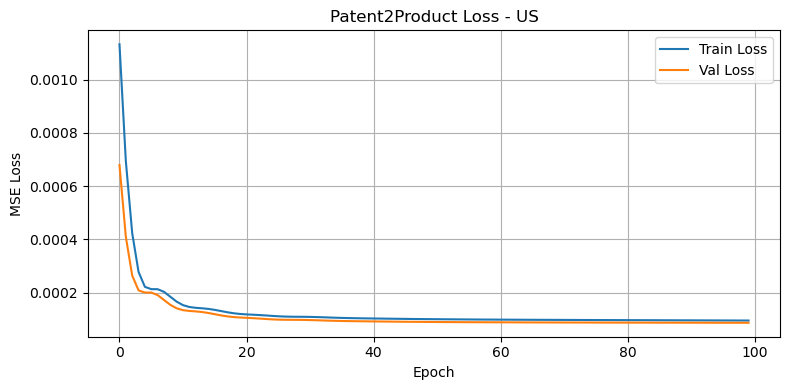

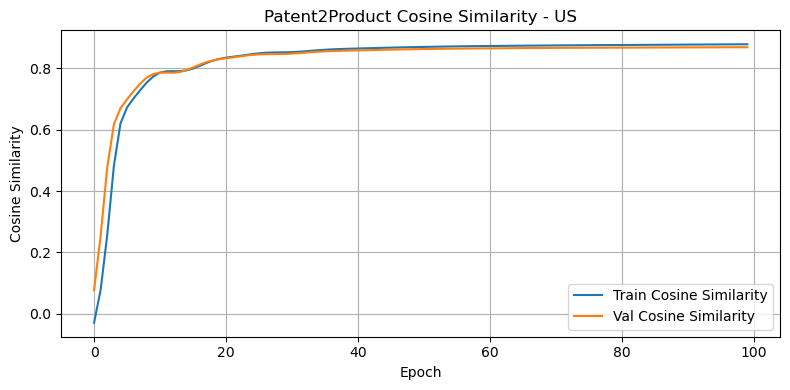

[A-US] Mean Cosine similarity: 0.8761, std: 0.0921


In [116]:
for country in models_A:
    print(f"\n[Evaluation A] {country}")

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses_A[country]['train'], label='Train Loss')
    plt.plot(losses_A[country]['val'], label='Val Loss')
    plt.title(f'Patent2Product Loss - {country}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot cosine similarity
    plt.figure(figsize=(8, 4))
    plt.plot(losses_A[country]['train_cos'], label='Train Cosine Similarity')
    plt.plot(losses_A[country]['val_cos'], label='Val Cosine Similarity')
    plt.title(f'Patent2Product Cosine Similarity - {country}')
    plt.xlabel('Epoch')
    plt.ylabel('Cosine Similarity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Final full cosine evaluation (on all data)
    model = models_A[country]
    model.eval()
    X_all = np.stack([patent_rep_dict[i] for i in shared_ids[country]])
    Y_all = np.stack([product_rep_dict[i] for i in shared_ids[country]])

    with torch.no_grad():
        pred_all = model(torch.tensor(X_all, dtype=torch.float32))
        cos_sims = torch.nn.functional.cosine_similarity(
            pred_all, torch.tensor(Y_all, dtype=torch.float32), dim=1
        ).numpy()
        print(f"[A-{country}] Mean Cosine similarity: {cos_sims.mean():.4f}, std: {cos_sims.std():.4f}")


## Model B (Product → Patent) → Technology vector = B × Market vector

In [117]:
class Product2Patent(nn.Module):
    def __init__(self, dim=ft_model.vector_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 512),
            nn.ReLU(),
            nn.Linear(512, dim)
        )
    def forward(self, x):
        return self.net(x)


In [118]:
for country, info in data_info.items():
    if country in ['CN', 'JP'] or len(shared_ids[country]) == 0:
        continue

    print(f"\n[Train B] Processing: {country}")
    
    # Prepare reversed data: X = Product, Y = Patent
    X_all = np.stack([product_rep_dict[i] for i in shared_ids[country]])
    Y_all = np.stack([patent_rep_dict[i] for i in shared_ids[country]])

    X_train, X_val, Y_train, Y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=42)

    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    Y_val = torch.tensor(Y_val, dtype=torch.float32)

    # Model & Optimizer
    model_B = Product2Patent()
    optimizer = optim.Adam(model_B.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    train_loss_B, val_loss_B = [], []
    train_cos_B, val_cos_B = [], []  # Track cosine similarity

    for epoch in range(EPOCH):
        model_B.train()
        optimizer.zero_grad()
        pred = model_B(X_train)
        loss = loss_fn(pred, Y_train)
        loss.backward()
        optimizer.step()
        train_loss_B.append(loss.item())

        # Cosine sim (train)
        cos_train = torch.nn.functional.cosine_similarity(pred, Y_train, dim=1).mean().item()
        train_cos_B.append(cos_train)

        # Validation
        model_B.eval()
        with torch.no_grad():
            val_pred = model_B(X_val)
            val_loss = loss_fn(val_pred, Y_val)
            val_loss_B.append(val_loss.item())

            cos_val = torch.nn.functional.cosine_similarity(val_pred, Y_val, dim=1).mean().item()
            val_cos_B.append(cos_val)

        print(f"[B-{country}] Epoch {epoch}: "
            f"Train Loss = {loss.item():.4f}, Val Loss = {val_loss.item():.4f}, "
            f"Train Cos = {cos_train:.4f}, Val Cos = {cos_val:.4f}")

    # Save model and loss
    models_B[country] = model_B
    losses_B[country] = {
        'train': train_loss_B,
        'val': val_loss_B,
        'train_cos': train_cos_B,
        'val_cos': val_cos_B
    }

    # Save transformation matrix B = W2 @ W1
    W1 = model_B.net[0].weight.detach().cpu().numpy()
    W2 = model_B.net[2].weight.detach().cpu().numpy()
    B = W2 @ W1
    transformation_matrices_B[country] = B



[Train B] Processing: US
[B-US] Epoch 0: Train Loss = 0.0014, Val Loss = 0.0009, Train Cos = 0.0233, Val Cos = 0.1093
[B-US] Epoch 1: Train Loss = 0.0009, Val Loss = 0.0006, Train Cos = 0.1090, Val Cos = 0.2398
[B-US] Epoch 2: Train Loss = 0.0006, Val Loss = 0.0004, Train Cos = 0.2400, Val Cos = 0.4193
[B-US] Epoch 3: Train Loss = 0.0004, Val Loss = 0.0003, Train Cos = 0.4197, Val Cos = 0.5842
[B-US] Epoch 4: Train Loss = 0.0003, Val Loss = 0.0003, Train Cos = 0.5846, Val Cos = 0.6716
[B-US] Epoch 5: Train Loss = 0.0003, Val Loss = 0.0003, Train Cos = 0.6717, Val Cos = 0.7082
[B-US] Epoch 6: Train Loss = 0.0003, Val Loss = 0.0003, Train Cos = 0.7079, Val Cos = 0.7303
[B-US] Epoch 7: Train Loss = 0.0003, Val Loss = 0.0002, Train Cos = 0.7298, Val Cos = 0.7510
[B-US] Epoch 8: Train Loss = 0.0003, Val Loss = 0.0002, Train Cos = 0.7503, Val Cos = 0.7721
[B-US] Epoch 9: Train Loss = 0.0002, Val Loss = 0.0002, Train Cos = 0.7712, Val Cos = 0.7916
[B-US] Epoch 10: Train Loss = 0.0002, Val Lo


[Evaluation B] US


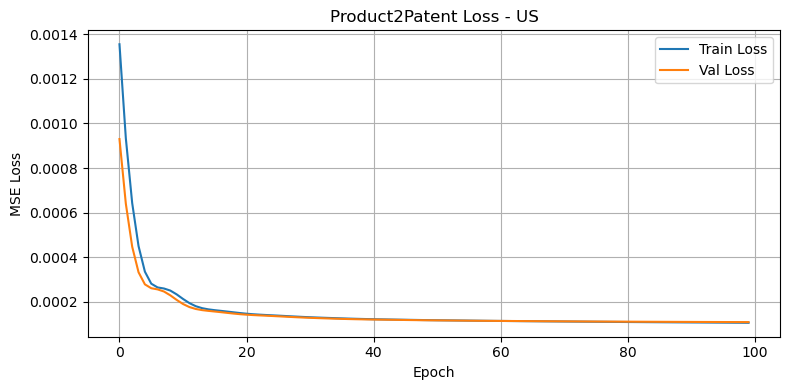

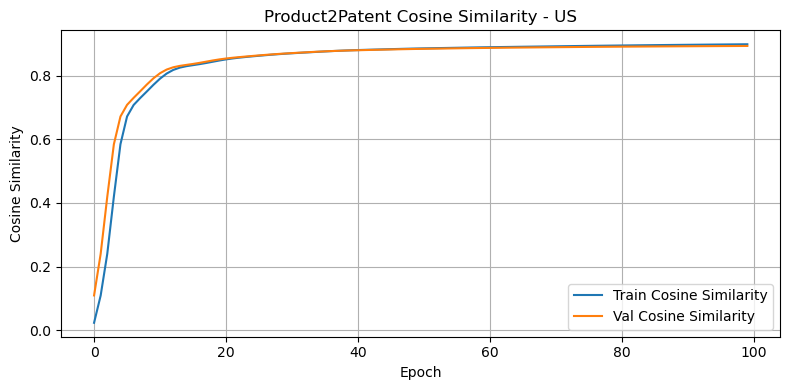

[B-US] Mean Cosine similarity: 0.8977, std: 0.0685


In [119]:
for country in models_B:
    print(f"\n[Evaluation B] {country}")

    # Plot loss
    plt.figure(figsize=(8, 4))
    plt.plot(losses_B[country]['train'], label='Train Loss')
    plt.plot(losses_B[country]['val'], label='Val Loss')
    plt.title(f'Product2Patent Loss - {country}')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot cosine similarity
    plt.figure(figsize=(8, 4))
    plt.plot(losses_B[country]['train_cos'], label='Train Cosine Similarity')
    plt.plot(losses_B[country]['val_cos'], label='Val Cosine Similarity')
    plt.title(f'Product2Patent Cosine Similarity - {country}')
    plt.xlabel('Epoch')
    plt.ylabel('Cosine Similarity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Cosine stats on all data
    model = models_B[country]
    model.eval()

    X_all = np.stack([product_rep_dict[i] for i in shared_ids[country]])
    Y_all = np.stack([patent_rep_dict[i] for i in shared_ids[country]])

    with torch.no_grad():
        pred_all = model(torch.tensor(X_all, dtype=torch.float32))
        cos_sims = torch.nn.functional.cosine_similarity(
            pred_all, torch.tensor(Y_all, dtype=torch.float32), dim=1
        ).numpy()
        print(f"[B-{country}] Mean Cosine similarity: {cos_sims.mean():.4f}, std: {cos_sims.std():.4f}")


# Step 8: Save model and apply it to full dataset

* Saves the trained model.

* Uses the model to generate product vectors for all firms (using their patent info).

* Saves final results to a new CSV file.

In [134]:
data_info["US"]

{'patent_file': './CN_JP_US_data/cleaned_patents.csv',
 'fasttext_model': 'fasttext_web_patent.vec',
 'output_model': './CN_JP_US_data/patent2product_us.pt'}

In [135]:
us_firms = keyword_df[keyword_df['Firm country'] == 'US']
missing_in_patent_dict = us_firms[~us_firms['Firm ID'].astype(str).isin(patent_rep_dict.keys())]

print(f"US firms total: {len(us_firms)}")
print(f"US firms missing in patent_rep_dict: {len(missing_in_patent_dict)}")


US firms total: 6764
US firms missing in patent_rep_dict: 3882


In [120]:
import os
import torch
import numpy as np

output_path = './CN_JP_US_data/DualAtt_Firm_Product_Keywords_Table_with_Vector.csv'

# Ensure the new column exists first
if 'Product embedding vector' not in keyword_df.columns:
    keyword_df['Product embedding vector'] = ""

for country, info in data_info.items():
    if country in ['CN', 'JP']:
        continue  # Skip these countries

    print(f"[PROCESS] {country} — Generating product vectors from patent vectors.")

    model = models_B[country]
    model.eval()

    # Get all indices from keyword_df where the firm is from the current country
    country_indices = keyword_df[keyword_df['Firm country'] == country].index

    for idx in country_indices:
        firm_id = str(keyword_df.at[idx, 'Firm ID'])

        if firm_id in patent_rep_dict:
            x_vec = torch.tensor(patent_rep_dict[firm_id], dtype=torch.float32).unsqueeze(0)  # shape: [1, D]
            with torch.no_grad():
                y_pred = model(x_vec).squeeze().numpy()  # shape: [output_dim]
            vector_str = '|'.join(map(str, y_pred))
            keyword_df.at[idx, 'Product embedding vector'] = vector_str

print(f"[SAVE] Writing output to: {output_path}")
keyword_df.to_csv(output_path, index=False)
print("[DONE] Results saved.")


[PROCESS] US — Generating product vectors from patent vectors.
[SAVE] Writing output to: ./CN_JP_US_data/DualAtt_Firm_Product_Keywords_Table_with_Vector.csv
[DONE] Results saved.


In [121]:
test = pd.read_csv(output_path)
test

Firm ID                                      Keywords list  \
0      700000  community|equipment|totaling|transit|highway|v...   
1      700001  manufactures|improvement|manufacture|improved|...   
2      700002  developer|media|property|consenting|partner|su...   
3      700003  outcomes|consisting|distribute|experience|insu...   
4      700004  virtually|potential|investments|integrates|str...   
...       ...                                                ...   
6759   706916  curtain|travel|inspiring|fiberglass|experience...   
6760   706917  outcomes|community|experience|specialized|regu...   
6761   706918  filings|followed|including|ideals|covering|dis...   
6762   706919  estimated|stickiness|insecticides|covering|com...   
6763   706920  cryptocurrency|filings|starting|websites|exper...   

                               Product embedding vector  \
0     -0.013949998|0.0073507037|0.02271974|0.0719459...   
1     -0.014604928|0.009685598|0.023527436|0.0622023...   
2                                                   NaN   
3                                                   NaN   
4                                                   NaN   
...                                                 ...   
6759  -0.012526467|0.009012576|0.019888224|0.0663081...   
6760                                                NaN   
6761                                                NaN   
6762                                                NaN   
6763                                                NaN   

                                Firm name Firm country  
0                        Warrior Met Coal           US  
1     MAGNACHIP SEMICONDUCTOR CORPORATION           US  
2                            Agree Realty           US  
3                    Ryan Specialty Group           US  
4                    CLEARSHARES OCIO ETF           US  
...                                   ...          ...  
6759           Armstrong World Industries           US  
6760                               R1 RCM           US  
6761              HENNESSY ADVISORS, INC.           US  
6762      GABELLI DIVIDEND & INCOME TRUST           US  
6763               SecureTech Innovations           US  

[6764 rows x 5 columns]

In [122]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6764 entries, 0 to 6763
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Firm ID                   6764 non-null   int64 
 1   Keywords list             6764 non-null   object
 2   Product embedding vector  2882 non-null   object
 3   Firm name                 6764 non-null   object
 4   Firm country              6764 non-null   object
dtypes: int64(1), object(4)
memory usage: 264.3+ KB


# Step 9: Export the transformation matrix

In [123]:
save_dir = './CN_JP_US_data/models'
os.makedirs(save_dir, exist_ok=True)

for country in models_A:
    # Save model A
    path_A = os.path.join(save_dir, f"{country}_Patent2Product.pt")
    torch.save(models_A[country].state_dict(), path_A)

    # Save matrix A
    matrix_A_path = path_A.replace('.pt', '_transform.npy')
    np.save(matrix_A_path, transformation_matrices_A[country])

for country in models_B:
    # Save model B
    path_B = os.path.join(save_dir, f"{country}_Product2Patent.pt")
    torch.save(models_B[country].state_dict(), path_B)

    # Save matrix B
    matrix_B_path = path_B.replace('.pt', '_transform.npy')
    np.save(matrix_B_path, transformation_matrices_B[country])

    print(f"[SAVE] {country}: Model A, B and matrices saved.")


[SAVE] US: Model A, B and matrices saved.


# Step 10: Test the result 

In [132]:
product_rep_dict


{'700000': array([-1.28888199e-02,  2.57826084e-03, -6.51552109e-04,  3.84409800e-02,
        -9.60310735e-03,  1.89111866e-02,  2.83981226e-02,  4.39503090e-03,
         7.22795166e-03,  7.66211050e-03,  2.39565223e-03,  2.44546570e-02,
         1.77782606e-02,  1.69316866e-03, -1.77080731e-03, -1.86186340e-02,
         1.97204947e-03,  3.53416312e-04,  5.52546512e-03, -2.35900539e-03,
        -2.55838502e-03, -2.24235989e-02,  3.72616955e-06,  8.81242100e-03,
        -6.04969217e-04, -5.14658401e-03, -1.27080653e-03, -1.28763979e-02,
         1.38229821e-02,  6.05900586e-02, -6.45963810e-05, -2.41242349e-03,
         4.82174056e-03, -1.59590114e-02, -6.80869725e-03, -9.55279451e-04,
         2.66459334e-04,  2.03292165e-03, -9.18385014e-03, -5.85652003e-03,
        -1.40919257e-02, -1.64503101e-02,  1.15763973e-02, -1.21962717e-02,
        -4.64558974e-02, -9.21118073e-03, -8.29192693e-04, -1.21763991e-02,
         1.10124249e-03, -2.39130415e-04,  1.00596305e-02, -1.07577641e-03,
  

In [136]:
from sklearn.metrics.pairwise import cosine_similarity
import torch
import numpy as np

# Matrix fallback (lightweight)
def query_opportunity_product_matrix_only(
    product_query_text,
    ft_model,
    mat_B, mat_A,
    patent_rep_dict,
    product_rep_dict,
    firm_id_name_map,
    firm_patent_ids,
    patent_text_map,
    top_k=5,
    show_patents_per_firm=3
):
    print("\n[Step 1] Embed user product query from individual words...")
    query_tokens = product_query_text.strip().split()
    token_vecs = [ft_model[w] for w in query_tokens if w in ft_model]

    if not token_vecs:
        print("❌ None of the tokens are in FastText vocabulary.")
        return

    market_vec = np.mean(token_vecs, axis=0)  # m_est
    print(f"📐 market_vec shape: {market_vec.shape}")  # (D,)

    print("\n[Step 2] Predict technical field vector using matrix B...")
    print(f"📐 mat_B shape: {mat_B.shape}")  # (D_patent, D_product)
    predicted_tech_field_vec = market_vec @ mat_B.T  # (D_patent,)
    print(f"📐 predicted_tech_field_vec shape: {predicted_tech_field_vec.shape}")

    print("\n[Step 3] Find top-k similar technical fields (field-level vectors)...")
    all_patent_vecs = np.stack(list(patent_rep_dict.values()))  # (N_patents, D_patent)
    
    all_firm_ids = list(patent_rep_dict.keys())
    all_patent_ids = list(patent_text_map.keys())  # NEW: Get all patent IDs
    
    print(f"📐 all_patent_vecs shape: {all_patent_vecs.shape}")

    sims = cosine_similarity([predicted_tech_field_vec], all_patent_vecs)[0]  # (N_patents,)
    print(f"📐 cosine similarities to patent field vectors shape: {sims.shape}")

    top_k_field_idx = sims.argsort()[-top_k:][::-1]

    # --- old code ---
    print("\n🔎 Top-k similar field-level patents (firm-level):")
    for rank, idx in enumerate(top_k_field_idx):
        firm_id = all_firm_ids[idx]
        firm_name = firm_id_name_map.get(firm_id, "Unknown")
        print(f"{rank+1}. Firm ID: {firm_id}, Name: {firm_name}, Cosine Sim: {sims[idx]:.4f}")
        
        patent_ids = firm_patent_ids.get(firm_id, [])
        if not patent_ids:
            print("     No associated patents found.")
            continue

        print(f"     Showing {min(show_patents_per_firm, len(patent_ids))} patent(s):")
        for p_id in patent_ids[:show_patents_per_firm]:
            abstract_preview = patent_text_map.get(p_id, "(no abstract)")
            print(f"       • appln_id: {p_id}, preview: {abstract_preview}")
    
    # --- new code --- 
    # print("\n🔎 Top-k similar patents (directly at patent-level):")
    # for rank, idx in enumerate(top_k_field_idx):
    #     patent_id = all_firm_ids[idx]  # Note: all_firm_ids actually contains patent-level keys here.
    #     firm_id = patent_id.split("_")[0] if "_" in patent_id else patent_id  # Adjust if needed for mapping.
    #     firm_name = firm_id_name_map.get(firm_id, "Unknown")
    #     abstract_preview = patent_text_map.get(patent_id, "(no abstract)")

    #     print(f"{rank+1}. Patent ID: {patent_id}, Firm ID: {firm_id}, Name: {firm_name}, Cosine Sim: {sims[idx]:.4f}")
    #     print(f"       • Abstract preview: {abstract_preview}")

    print("\n[Step 4] Map predicted technical field vector back to predicted market field vector using matrix A...")
    print(f"📐 mat_A shape: {mat_A.shape}")  # (D_product, D_patent)
    predicted_market_field_vec = predicted_tech_field_vec @ mat_A.T  # (D_product,)
    print(f"📐 predicted_market_field_vec shape: {predicted_market_field_vec.shape}")

    print("\n[Step 5] Find top-k similar company market vectors (firm-level)...")
    all_product_vecs = np.stack(list(product_rep_dict.values()))  # (N_firms, D_product)
    all_firm_ids_product = list(product_rep_dict.keys())
    print(f"📐 all_product_vecs shape: {all_product_vecs.shape}")

    sims_firm = cosine_similarity([predicted_market_field_vec], all_product_vecs)[0]  # (N_firms,)
    print(f"📐 cosine similarities to firm product vectors shape: {sims_firm.shape}")

    top_k_firm_idx = sims_firm.argsort()[-top_k:][::-1]

    print("\n🏢 Top-k firms likely aligned with your product:")
    for rank, idx in enumerate(top_k_firm_idx):
        firm_id = all_firm_ids_product[idx]
        firm_name = firm_id_name_map.get(firm_id, "Unknown")
        print(f"{rank+1}. Firm ID: {firm_id}, Name: {firm_name}, Cosine Sim: {sims_firm[idx]:.4f}")

# Full model path (best quality)	
def query_opportunity_product_best(
    product_query_text,
    ft_model,
    model_B, model_A,
    patent_rep_dict,
    product_rep_dict,
    firm_id_name_map,
    firm_patent_ids,
    patent_text_map,
    top_k=5,
    show_patents_per_firm=3
):
    print("\n[Step 1] Embed user product query from individual words...")
    query_tokens = product_query_text.strip().split()
    token_vecs = [ft_model[w] for w in query_tokens if w in ft_model]

    if not token_vecs:
        print("❌ None of the tokens are in FastText vocabulary.")
        return

    product_vec = np.mean(token_vecs, axis=0)
    product_tensor = torch.tensor(product_vec, dtype=torch.float32).unsqueeze(0)

    print("\n[Step 2] Predict technical field vector using model B (nonlinear)...")
    with torch.no_grad():
        patent_tensor = model_B(product_tensor)  # shape: (1, D_patent)
        predicted_patent_vec = patent_tensor.squeeze().numpy()

    print("\n[Step 3] Find top-k similar technical fields (patents)...")
    all_patent_vecs = np.stack(list(patent_rep_dict.values()))
    all_firm_ids = list(patent_rep_dict.keys())

    sims = cosine_similarity([predicted_patent_vec], all_patent_vecs)[0]
    top_k_field_idx = sims.argsort()[-top_k:][::-1]

    print("\n🔎 Top-k similar field-level patents (firm-level):")
    for rank, idx in enumerate(top_k_field_idx):
        firm_id = all_firm_ids[idx]
        firm_name = firm_id_name_map.get(firm_id, "Unknown")
        print(f"{rank+1}. Firm ID: {firm_id}, Name: {firm_name}, Cosine Sim: {sims[idx]:.4f}")
        
        patent_ids = firm_patent_ids.get(firm_id, [])
        if not patent_ids:
            print("     No associated patents found.")
            continue

        print(f"     Showing {min(show_patents_per_firm, len(patent_ids))} patent(s):")
        for p_id in patent_ids[:show_patents_per_firm]:
            abstract_preview = patent_text_map.get(p_id, "(no abstract)")
            print(f"       • appln_id: {p_id}, preview: {abstract_preview}")

    print("\n[Step 4] Map predicted patent vector back to market vector using model A (nonlinear)...")
    with torch.no_grad():
        market_tensor = model_A(patent_tensor)  # shape: (1, D_product)
        predicted_market_field_vec = market_tensor.squeeze().numpy()

    print("\n[Step 5] Find top-k companies (firm-level product vectors) similar to this predicted market field...")
    all_product_vecs = np.stack(list(product_rep_dict.values()))
    all_product_firms = list(product_rep_dict.keys())

    sims_firm = cosine_similarity([predicted_market_field_vec], all_product_vecs)[0]
    top_k_firm_idx = sims_firm.argsort()[-top_k:][::-1]

    print("\n🏢 Top-k firms likely aligned with your product:")
    for rank, idx in enumerate(top_k_firm_idx):
        firm_id = all_product_firms[idx]
        firm_name = firm_id_name_map.get(firm_id, "Unknown")
        print(f"{rank+1}. Firm ID: {firm_id}, Name: {firm_name}, Cosine Sim: {sims_firm[idx]:.4f}")





In [140]:
query_opportunity_product_matrix_only(
    # product_query_text="methods for directing waste gases",
    product_query_text="automotive car",
    ft_model=ft_model,
    mat_B=transformation_matrices_B['US'],
    mat_A=transformation_matrices_A['US'],
    patent_rep_dict=patent_rep_dict,
    product_rep_dict=product_rep_dict,
    firm_id_name_map=firm_id_name_map,
    firm_patent_ids=firm_patent_ids,
    patent_text_map=patent_text_map,
    top_k=5
)



[Step 1] Embed user product query from individual words...
📐 market_vec shape: (300,)

[Step 2] Predict technical field vector using matrix B...
📐 mat_B shape: (300, 300)
📐 predicted_tech_field_vec shape: (300,)

[Step 3] Find top-k similar technical fields (field-level vectors)...
📐 all_patent_vecs shape: (2922, 300)
📐 cosine similarities to patent field vectors shape: (2922,)

🔎 Top-k similar field-level patents (firm-level):
1. Firm ID: 705346, Name: PERFICIENT INC, Cosine Sim: 0.0385
     Showing 3 patent(s):
       • appln_id: 57950012, preview: system generation account payable processing system tax rule provided tax account system generates account tax jurisdiction rule system generates one
       • appln_id: 353623082, preview: system including agent information system configured expose agent information federated service provider communication interface configured receive call computer coupled agent
       • appln_id: 365479165, preview: system generation account payable proc

In [142]:
query_opportunity_product_best(
    # product_query_text="methods for directing waste gases",
    product_query_text="computer vision and machine learning",
    ft_model=ft_model,
    model_B=models_B['US'],                 # nonlinear model from product → patent space
    model_A=models_A['US'],                 # nonlinear model from patent → product space
    patent_rep_dict=patent_rep_dict,        # {firm_id: tech field vector}
    product_rep_dict=product_rep_dict,      # {firm_id: product vector}
    firm_id_name_map=firm_id_name_map,      # {firm_id: readable company name}
    firm_patent_ids=firm_patent_ids,        # {firm_id: list of patent appln_ids}
    patent_text_map=patent_text_map,        # {appln_id: abstract preview} ==> if just want to keywords of the patent abstract, use `clean_abstract` column
    top_k=5                                 # number of top firms or fields to show
)



[Step 1] Embed user product query from individual words...

[Step 2] Predict technical field vector using model B (nonlinear)...

[Step 3] Find top-k similar technical fields (patents)...

🔎 Top-k similar field-level patents (firm-level):
1. Firm ID: 703151, Name: Apple, Cosine Sim: 0.9718
     Showing 3 patent(s):
       • appln_id: 463414, preview: one embodiment present invention provides apparatus measure produced switching regulator within electronic device apparatus includes coupled switching fet within switching
       • appln_id: 463503, preview: modulation system includes amplitude modulation path phase modulation path coupled amplitude modulation path one amplitude modulation path phase modulation path
       • appln_id: 463527, preview: compact magnetic cable noise suppressor may provided suppressing electromagnetic cable noise compact magnetic noise suppressor may formed ferrite material magnetic
2. Firm ID: 703595, Name: NCR, Cosine Sim: 0.9689
     Showing 3 patent(s):
 